### Outlier Detection
---
The simplest way to detect potential fraud is by identifying transactions that stand out as unusual. By "unusual," we mean cases where certain characteristics differ significantly from typical patterns.

Below are some commonly used methods for detecting outliers:

1️⃣ Z-score (Statistic-based)  
2️⃣ Interquartile Range (IQR) (Statistic-based)  
3️⃣ Density-Based Spatial Clustering of Applications with Noise (DBSCAN) (Density-based)  
4️⃣ Gaussian Mixiture Model (GMM) (Probability-based)   
5️⃣ K-Nearest Neighbors (KNN) (Distance-based)

First, I use the **Z-score** and **IQR** methods only for **continuous** data, skipping anything with distinct categories. These methods aren't useful for spotting unusual values in things like color labels (`red = 0`, `blue = 1`), where it doesn't make sense to look for "outliers."

Next, I test other **unsupervised** machine learning methods without relying on fraud indicators in the data.

One big advantage of unsupervised learning is that it doesn’t need pre-labeled examples to learn from. In contrast, **supervised** learning requires a dataset with correct answers—something that takes a lot of time and effort to put together. Unsupervised learning can find patterns on its own, making it useful when labeled data isn’t available.

This makes unsupervised learning especially helpful for tasks like grouping similar things together, spotting oddities in data, and simplifying complex information. It’s like letting AI explore freely instead of only learning from predefined examples.

### [Bank Account Fraud Dataset Suite (NeurIPS 2022)](https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022) loading from Kaggle onto Google Colab
---

In [1]:
# The keyword "pandas==" without prefix "^" fetches the following entry that is NOT wanted
#   sklearn-pandas==2.2.0
!pip freeze | grep -E '^tqdm==|^pandas==|^google=='

google==2.0.3
pandas==2.2.2
tqdm==4.67.1


In [2]:
import os
from google.colab import userdata

# Copy Colab secrets as env vars
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [3]:
!pwd

/content


In [4]:
# `import opendatasets as od` might not be flexible, so just make direct Kaggle API calls
from kaggle.api.kaggle_api_extended import KaggleApi
from tqdm import tqdm

# Initialize Kaggle API
api = KaggleApi()

# This authenticate() first looks for ~/.config/kaggle/kaggle.json (downloaded from Kaggle | Settings | API | Create New Token that includes username and API key)
# If the JSON file is not present the command looks into the env vars
api.authenticate()

# Dataset identifier
owner = "sgpjesus"
dataset = "bank-account-fraud-dataset-neurips-2022"
owner_and_dataset_name = owner + "/" + dataset
download_zip_file_name = dataset + ".zip"
extracted_csv_file_name = "Base.csv"

# Get dataset metadata to retrieve file size
dataset_metadata = api.dataset_list_files(owner_and_dataset_name).files

In [5]:
import pprint
pprint.pprint(dataset_metadata)

[{"ref": "", "datasetRef": "", "ownerRef": "", "name": "Base.csv", "creationDate": "2023-11-29T11:32:19.356Z", "description": "", "fileType": "", "url": "", "totalBytes": 213427735, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant I.csv", "creationDate": "2023-11-29T11:32:19.724Z", "description": "", "fileType": "", "url": "", "totalBytes": 213400445, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant II.csv", "creationDate": "2023-11-29T11:32:19.511Z", "description": "", "fileType": "", "url": "", "totalBytes": 213537521, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant III.csv", "creationDate": "2023-11-29T11:32:21.193Z", "description": "", "fileType": "", "url": "", "totalBytes": 252204320, "columns": []},
 {"ref": "", "datasetRef": "", "ownerRef": "", "name": "Variant IV.csv", "creationDate": "2023-11-29T11:32:20.744Z", "description": "", "fileType": "", "url": "", "totalBytes": 213538370, "c

In [6]:
api.dataset_metadata(owner_and_dataset_name, path=".")
!cat ./dataset-metadata.json

"{\"datasetId\": 2673949, \"datasetSlug\": \"bank-account-fraud-dataset-neurips-2022\", \"ownerUser\": \"sgpjesus\", \"usabilityRating\": 1.0, \"totalViews\": 98668, \"totalVotes\": 174, \"totalDownloads\": 15301, \"title\": \"Bank Account Fraud Dataset Suite (NeurIPS 2022)\", \"subtitle\": \"Biased, Imbalanced, Dynamic Tabular Datasets for ML Evaluation.\", \"description\": \"The Bank Account Fraud (BAF) suite of datasets has been published at **NeurIPS 2022** and it comprises a total of 6 different synthetic bank account fraud tabular datasets. BAF is a realistic, complete, and robust test bed to evaluate novel and existing methods in ML and fair ML, and the first of its kind!\\n\\n\\n**This suite of datasets is:**\\n- Realistic, based on a present-day real-world dataset for fraud detection;\\n- Biased, each dataset has distinct controlled types of bias;\\n- Imbalanced, this setting presents a extremely low prevalence of positive class;\\n- Dynamic, with temporal data and observed di

In [7]:
total_csv_file_size = sum([csv_file.total_bytes for csv_file in dataset_metadata])

# Download dataset with progress tracking
with tqdm(total=total_csv_file_size, unit='B', unit_scale=True, unit_divisor=1024, desc="Downloading Dataset") as bar:
    api.dataset_download_files(owner_and_dataset_name, path=".", unzip=False)
    downloaded_size = os.path.getsize(download_zip_file_name)
    bar.update(downloaded_size)

print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022


Download complete!


In [8]:
#import zipfile module
from zipfile import ZipFile

with ZipFile(dataset + ".zip", "r") as f:
  #extract only one file, Base.csv, in current directory
  f.extract(extracted_csv_file_name)

### Feature Engineering
---
It enhances feature quality and relevance and creates or modifies features to enhance predictive power by transforming raw data into a more useful representation, such as:  
*   Creating new features (e.g., deriving "age group" from "age").  
*   Transforming existing features (e.g., normalizing values).
*   Handling missing values (e.g., imputing missing data).  
*   Encoding categorical variables (e.g., one-hot encoding).

In [9]:
### Libraries ###
import time
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.stats import zscore

# -----------------------
# Unsupervised machine learning methods
# -----------------------
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

# -----------------------
# Supervised machine learning methods
# -----------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from sklearn.neural_network import MLPClassifier

# -----------------------
# Imbalanced data solutions
# -----------------------
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# -----------------------
# Scikit-learn toos
# -----------------------
from sklearn.preprocessing import (
  StandardScaler,
  MinMaxScaler
)

from sklearn.metrics import (
  confusion_matrix,
  precision_recall_curve,
  precision_score,
  recall_score,
  f1_score,
  average_precision_score,
  classification_report,
  roc_curve,
  auc,
  precision_recall_fscore_support,
  roc_auc_score
)

from sklearn.model_selection import (
  train_test_split,
  StratifiedKFold,
  cross_val_predict,
  GridSearchCV
)

from sklearn.feature_selection import (
  mutual_info_classif,
  RFE
)

In [10]:
### Labels ###
LABEL_TRUE = "True"
LABEL_FALSE = "False"

LABEL_CELL_ANNOTATION = "Cell Annotation"
LABEL_TARGET = "fraud_bool"
LABEL_ZSCORE = "Z-score"
LABEL_IQR = "IQR"
LABEL_OUTLIER_COUNT = "Outlier Counts"
LABEL_FEATURE = "Feature"
LABEL_COUNT = "Counts"
LABEL_FRAUD_COUNT = "Fraud Cases"
LABEL_FRAUD = "Fraud"
LABEL_METHOD = "Method"
LABEL_VALUE = "Values"
LABEL_HEATMAP_COOLWARM = "coolwarm"
LABEL_OBJECT = "object"

LABEL_RANDOM_FOREST = "Random Forest"
LABEL_LOGISTIC_REGRESSION = "Logistic Regresion"
LABEL_XGB_BOOST = "eXtreme Gradient Boosting"
LABEL_NEURAL_NETWORK = "Neural Network"

LABEL_PREDICTED_VALUES = "Predicted Values"
LABEL_PRECISION = "Precision"
LABEL_RECALL = "Recall"
LABEL_F1SCORE = "F1-score"
LABEL_MODEL = "Model"
LABEL_ROC_AUC = "ROC_AUC"
LABEL_PR_AUC = "PR-AUC"
LABEL_DURATION = "Duration"
LABEL_BINARY = "binary"

LABEL_FALSE_POSITIVE = "False Positive Rate"
LABEL_TRUE_POSITIVE = "True Negative Rate"

TRAIN_TEST_SPLIT_SIZE = 0.2
FORMAT_DECIMALS = ".2f"

# Number 42 is just a "seed" number which used to set the seed for the random number generator. Both random_state and seed are used to ensure that the same random numbers
#  are generated every time the code is run, which makes the results reproducible. It is not mandatory to use 42 only.
# What is the significance of random. seed(42)? It's a pop-culture reference! In Douglas Adams's popular 1979 science-fiction novel The Hitchhiker's Guide to the Galaxy,
#  towards the end of the book, the supercomputer Deep Thought reveals that the answer to the great question of “life, the universe and everything” is 42.
RANDOM_STATE_NUM = 42

In [11]:
# Define a function to format the ticks
def format_thousands(x):
    return f"{int(x):,}"

# def add_thousand_separator_to_int(num: int) -> str:
#   return "{:,}".format(num)

# def format_thousands(var) -> str:
#   return f"{var:,.0f}" if type(var) == int or type(var) == float else "{x:,.0f}"

In [23]:
def measure_duration(start_time: float, isLabelRequired: bool=False) -> str:
  end_time = time.time()
  duration = end_time - start_time
  hours = int(duration // 3600)
  minutes = int((duration % 3600) // 60)
  seconds = duration % 60

  _label = "Duration: " if isLabelRequired else ""
  return f"{_label}{round(hours):02}h{round(minutes):02}m{round(seconds):02}s"

In [12]:
pd.set_option("display.max_columns", None)
df = pd.read_csv(extracted_csv_file_name)
print(df.head())

   fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w   velocity_6h  \
0              102.453711           AA          1059  13096.0350

In [13]:
# The number of columns
print(df.shape[1])

32


In [14]:
print(df.describe())

           fraud_bool          income  name_email_similarity  \
count  1000000.000000  1000000.000000         1000000.000000   
mean         0.011029        0.562696               0.493694   
std          0.104438        0.290343               0.289125   
min          0.000000        0.100000               0.000001   
25%          0.000000        0.300000               0.225216   
50%          0.000000        0.600000               0.492153   
75%          0.000000        0.800000               0.755567   
max          1.000000        0.900000               0.999999   

       prev_address_months_count  current_address_months_count  \
count             1000000.000000                1000000.000000   
mean                   16.718568                     86.587867   
std                    44.046230                     88.406599   
min                    -1.000000                     -1.000000   
25%                    -1.000000                     19.000000   
50%                    -1.0

In [15]:
# This stats table omits categorical values!
print(df.describe().shape[1])

27


In [16]:
# Drop the "device_fraud_count" column as it contains all zeros
df = df.drop("device_fraud_count", axis=1)

In [17]:
print("The numbere of missing data cell count = " + str(df.isnull().any(axis=1).sum()))

The numbere of missing data cell count = 0


In [18]:
print(df.dtypes)

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

In [19]:
X = df.copy()

# Seprate the dependent/target variable
y = X.pop(LABEL_TARGET)

# Loop through every column
for column in X.columns:
    # Check if the column is of type 'int64' and contains only 0 and 1
    if X[column].dtype == "int64" and X[column].isin([0, 1]).all():
        # Convert to boolean type
        X[column] = X[column].astype(bool)

print(X.dtypes)

income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                          bool
housing_status                       object
phone_home_valid                       bool
phone_mobile_valid                     bool
bank_months_count                     int64
has_other_cards                        bool
proposed_credit_limit           

In [20]:
# There is no point of applying correlation or StandardScaler on "bool" and "object (string)"" as they would be meaningless
# Cannot remove both at one go, so one by one
X_no_bool = X.select_dtypes(exclude=bool)
X_no_string_or_bool = X_no_bool.select_dtypes(exclude=[LABEL_OBJECT])

### Normally Distributed or Skewed?
---
The distribution of a dataset—whether it's normally distributed or skewed—affects both outlier detection and the performance of machine learning models.

1. Outlier Detection Sensitivity  
    - Many standard outlier detection methods, such as Z-score or Modified Z-score, assume a normal distribution. These methods identify outliers based on statistical deviations from the mean, but if the dataset is skewed, they may incorrectly classify extreme values as outliers.

    - For skewed data, techniques like the Interquartile Range (IQR) or Robust Statistical Methods (such as median-based techniques) work better.

2. Impact on Machine Learning Models  
    - Some algorithms, like linear regression, logistic regression, and support vector machines (SVMs), assume or work best with normally distributed features. Skewed data can lead to biased predictions or ineffective learning.

    - Tree-based models (like decision trees and random forests) are less sensitive to data distribution, but extreme skewness may still affect performance.

    - Many machine learning models rely on standardization (e.g., Min-Max Scaling or Z-score Normalization) to ensure balanced learning. If data is highly skewed, log transformation or Box-Cox transformation may be required before training.

3. Avoiding Bias & Improving Interpretability  
    - If a dataset is skewed, summary statistics like mean and standard deviation may not accurately represent the data. In this case, relying on the median and interquartile range often provides a clearer understanding.

    - A skewed dataset might indicate an underlying issue, such as data collection bias or natural asymmetry in the population, which could require additional preprocessing steps.

Outliers play a significant role in how **StandardScaler** and **MinMaxScaler** transform data, which can lead to differences in their resulting shapes.

Here's why:

1. StandardScaler (Z-score normalization)
   - Centers the data (zero mean) and scales it to unit variance.  
   - Outliers stretch the scale, influencing the mean and standard deviation.  
   - This can cause a more spread-out distribution in the transformed data.

2. MinMaxScaler (Range normalization)
   - Scales values to a fixed range, typically `[0,1]`.  
   - Outliers compress the distribution, pushing regular values closer together.  
   - This leads to more skewed and squeezed transformations if extreme values are present.

Why do their shapes differ?  
- If there are many outliers, StandardScaler will maintain a broader spread, whereas MinMaxScaler will compress most values into a tight range while stretching extreme ones.  
- This results in different distributions and potentially distinct shapes when visualizing the scaled data.



In [21]:
def draw_boxplot(data: pd.DataFrame,
                 title: str,
                 ylabel: str,
                 xlabel: str) -> None:
  plt.figure(figsize=(6, 4))
  sns.boxplot(data=data, orient="h") # Flips x and y axes by "orient="h"
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid(True)
  plt.show()

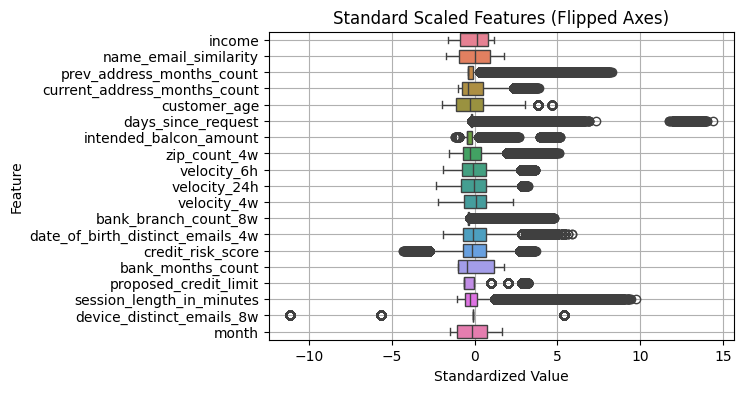

In [22]:
scaler = StandardScaler()
X_standard_scaled = pd.DataFrame(scaler.fit_transform(X_no_string_or_bool), columns=X_no_string_or_bool.columns)

draw_boxplot(X_standard_scaled,
             "Standard Scaled Features (Flipped Axes)",
             LABEL_FEATURE,
             "Standardized Value")

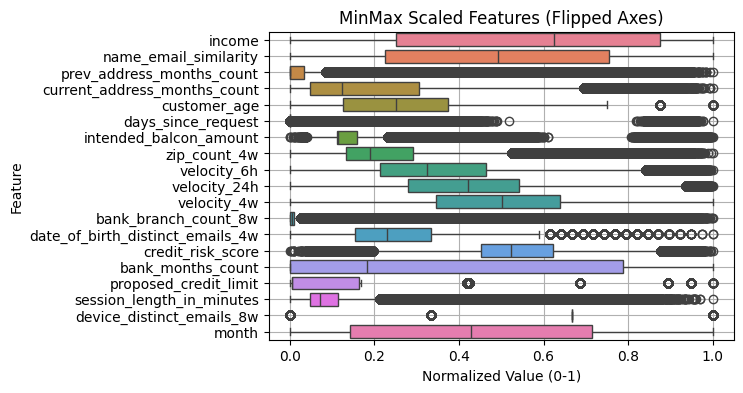

In [ ]:
# Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_scaled = pd.DataFrame(minmax_scaler.fit_transform(X_no_string_or_bool), columns=X_no_string_or_bool.columns)

draw_boxplot(X_minmax_scaled,
             "MinMax Scaled Features (Flipped Axes)",
             LABEL_FEATURE,
             "Normalized Value (0-1)")

#### 1. Statistic-based Method (Z-score and IQR)
---
When **Z-score** is more useful than **IQR**?  
1. When Data is Normally Distributed (Bell-Shaped)
    - Z-score assumes data follows a Gaussian (normal) distribution.
    - If your dataset is symmetric and bell-shaped, Z-score is ideal because it standardizes values based on mean and standard deviation.

2. When Detecting Outliers in Continuous Data
    - Works best for datasets with continuous numerical values, such as age, income, or temperatures.
    - Since Z-score transforms values into a standardized scale, it effectively spots extreme deviations.

3. When Working with Large Datasets
    - In massive datasets, IQR can struggle to detect subtle variations.
    - Z-score scales well and provides a more precise measure of how far a data point deviates from the mean.

4. When You Need a Standardized Measure for Comparison
    - Z-score allows comparisons across different datasets.
    - For example, if two different datasets have different scales (one in dollars, another in kilograms), Z-score makes values comparable by converting them to standard deviations.

5. When You Expect Global Outliers (Extreme Deviations)
    - Z-score effectively captures global outliers, meaning data points that are extremely different from the overall dataset.
    - IQR is better at detecting local outliers, meaning values that might be extreme in a specific subset but not necessarily across the entire dataset.


In [ ]:
def get_zscore_per_col(series: pd.Series) -> pd.Series:
    return np.abs(zscore(series)) > 3

def get_iqr_per_col(series: pd.Series) -> pd.Series:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))

In [ ]:
outlier_method_and_result_list = [[LABEL_ZSCORE], [LABEL_IQR]]

# Initialize outlier counter
outlier_counter = pd.Series(0, index=df.index, name = LABEL_OUTLIER_COUNT)

for method_idx in range(len(outlier_method_and_result_list)):
  # No point in using "X_standard_scaled" as the base dataframe because it is normalised with mean of 0 and st. dev. of 1, effectively having removed outlier-ness.
  for col in X_no_string_or_bool.columns:
    match str(outlier_method_and_result_list[method_idx][0]):
      case "Z-score":
        outlier_counts = get_zscore_per_col(X_no_string_or_bool[col])
      case "IQR":
        outlier_counts = get_iqr_per_col(X_no_string_or_bool[col])
      case _: # the default wild card
        print("Error")

    # Count outliers per row
    outlier_counter += outlier_counts.astype(int)

  # Add two Series together into a new DataFrame
  X_fraud_bool_and_outlier_counter = pd.concat([y, outlier_counter], axis=1)

  # Group by "LABEL_OUTLIER_COUNT" and sum the "LABEL_TARGET"
  # Convert back to a regular DataFrame using the reset_index() method
  X_fraud_bool_and_outlier_counter_grouped = X_fraud_bool_and_outlier_counter.groupby(LABEL_OUTLIER_COUNT)[LABEL_TARGET].sum().reset_index()

  # Add it to the list as a second element
  outlier_method_and_result_list[method_idx].append(X_fraud_bool_and_outlier_counter_grouped)

In [ ]:
def draw_outlier_barplot(data: pd.DataFrame,
                 title_name: str) -> None:
  plt.figure(figsize=(5, 3))
  ax = sns.barplot(x=LABEL_OUTLIER_COUNT, y=LABEL_TARGET, data=data)
  ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
  ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

  for idx in range(len(data)):
      ax.text(idx, data[LABEL_TARGET][idx] + 50, f"{data[LABEL_TARGET][idx]:,.0f}", ha="center", fontsize=10)

  # Adding labels and title
  plt.xlabel(LABEL_OUTLIER_COUNT)
  plt.ylabel(LABEL_FRAUD_COUNT)
  plt.title(title_name)
  plt.show()

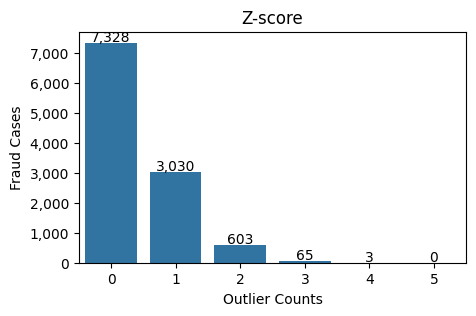

In [ ]:
draw_outlier_barplot(outlier_method_and_result_list[0][1], LABEL_ZSCORE)

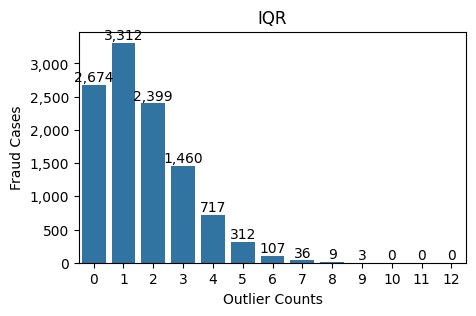

In [ ]:
draw_outlier_barplot(outlier_method_and_result_list[1][1], LABEL_IQR)

The two histograms above indicate that detecting more outliers in features does not necessarily improve fraud detection. In fact, features with fewer outlier counts tend to correspond to a higher number of fraud cases.

Let's take a closer look at the features with the highest outlier counts that are also marked as "fraud."

In [ ]:
# Initialize an empty dataframe
df_feature_outlier_result = pd.DataFrame(columns=[LABEL_FEATURE, LABEL_COUNT], dtype=int)

# Initialize outlier counter
outlier_flag_series = pd.Series(0, index=df.index, name = LABEL_OUTLIER_COUNT)

for method_idx in range(len(outlier_method_and_result_list)):
  for col in X_no_string_or_bool.columns:
    match str(outlier_method_and_result_list[method_idx][0]):
      case "Z-score":
        outlier_flag_series = get_zscore_per_col(X_no_string_or_bool[col])
      case "IQR":
        outlier_flag_series = get_iqr_per_col(X_no_string_or_bool[col])
      case _: # the default wild card
        print("Error")

    # Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
    # No need to specify column name for a Series like:
    #   count = (y[LABEL_TARGET] * outlier_flag_series[outlier_count_col_title] == 1).sum()
    count = (y * outlier_flag_series == 1).sum()

    # Add the result to the first dataframe using loc
    df_feature_outlier_result.loc[len(df_feature_outlier_result)] = [col, count]

  # Add it to the list as a second element
  outlier_method_and_result_list[method_idx].append(df_feature_outlier_result.copy(deep=True))

  # This removes all rows but retains the column names and data types.
  df_feature_outlier_result.drop(df_feature_outlier_result.index, inplace=True)

In [ ]:
def draw_outlier_by_feature_barplot(data: pd.DataFrame,
                                    method_name: str) -> None:
# data:
#     Feature Count
# 18 	None 	None
# 19 	income 	0
# 21 	prev_address_months_count 	575

# In a row, When 'Feature' and 'Count' shows
# 1. Both 'None'
#   The particular feature is never counted as an outlier by the method chosen
# 2. Feature name printed and 0
#   The particular feature is counted as an outlier BUT no fraud case is found when its value is an ourlier
# 3. Feature name printed and non-zero
#   The particular feature is counted as an outlier AND one or more fraud case is found

  # Drop rows where both 'Feature' and 'Count' are None
  data_none_removed = data.dropna(subset=[LABEL_FEATURE, LABEL_COUNT], how="all")

  # Sort in a descending order
  data_none_removed = data_none_removed.sort_values(by=LABEL_COUNT, ascending=False)

  plt.figure(figsize=(5, 3))
  ax = sns.barplot(x=LABEL_COUNT, y=LABEL_FEATURE, data=data_none_removed, orient="h")

  # Do not need this as the Y-axis shows categorical values, only the X-axis
  ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
  ax.bar_label(ax.containers[0], fmt="{:,.0f}")

  # Adding labels and title
  plt.xlabel(LABEL_FRAUD_COUNT)
  plt.ylabel(LABEL_FEATURE)
  plt.title(method_name)
  plt.show()

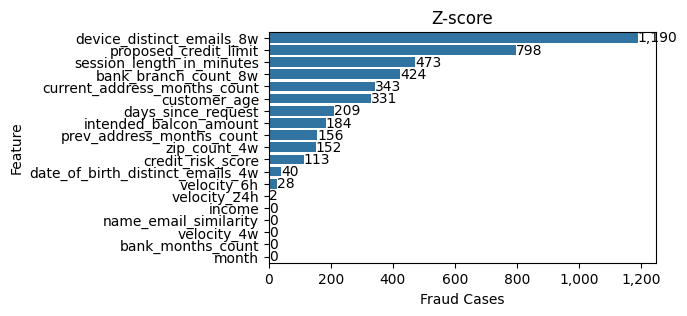

In [ ]:
draw_outlier_by_feature_barplot(outlier_method_and_result_list[0][2], LABEL_ZSCORE)

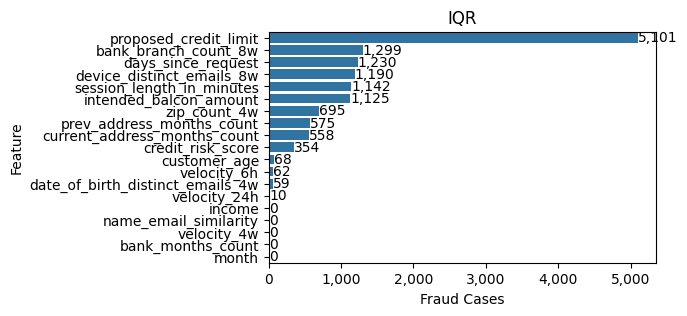

In [ ]:
draw_outlier_by_feature_barplot(outlier_method_and_result_list[1][2], LABEL_IQR)

Based on the observed outliers, the **proposed_credit_limit** identified by the IQR method carries more weight in predicting fraud than **device_distinct_emails_8w** identified by the Z-score method.

I have not overlooked binary and categorical features. I briefly examine them to determine if any notable patterns emerge in relation to detected fraud.

In [ ]:
def get_fraud_count_by_single_dtype(df: pd.DataFrame, dtype_name: str) -> list:
  df_selected_dtype = df.select_dtypes(dtype_name)
  list_of_list_col_names = [[col_name] for col_name in df_selected_dtype.columns]

  for list_col in list_of_list_col_names:
    # put 'fraud_bool' (y) and a boolean/encoded valued column together into a new DataFrame
    df_concatenated = pd.concat([y,  df_selected_dtype[list_col[0]]], axis=1)

    # Change column names for FacetGrid later
    df_concatenated.rename(columns={list_col[0]: LABEL_VALUE}, inplace=True)
    df_concatenated.rename(columns={LABEL_TARGET: LABEL_FRAUD_COUNT}, inplace=True)

    # Group by "LABEL_VALUE" and sum the "label_fraud_count"
    # Convert back to a regular DataFrame using the reset_index() method
    df_concatenated_grouped = df_concatenated.groupby(LABEL_VALUE)[LABEL_FRAUD_COUNT].sum().reset_index()

    # Add it to the list as a second element
    list_col.append(df_concatenated_grouped)

  return list_of_list_col_names


def get_fraud_count_in_facetgrid(list_source: list) -> None:
  # Combine data into a single DataFrame
  # Need to use "##{varName}" to dynamically assign a variable name as a column name of the combined DataFrame
  df_combined = pd.concat(
      [df_bool.assign(**{LABEL_FEATURE:feature_name}) for feature_name, df_bool in list_source],
      ignore_index=True
  )

  g = sns.FacetGrid(df_combined, col=LABEL_FEATURE, height=3, aspect=0.8)
  ax = sns.barplot
  g.map_dataframe(ax, x=LABEL_VALUE, y=LABEL_FRAUD_COUNT)

  g.set(xlabel=None)

  # Apply the formatter to each axis in the FacetGrid
  for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax.bar_label(ax.containers[0], fmt="{:,.0f}")
  plt.show()

In [ ]:
list_bool_fraud_counts = get_fraud_count_by_single_dtype(X, 'bool')

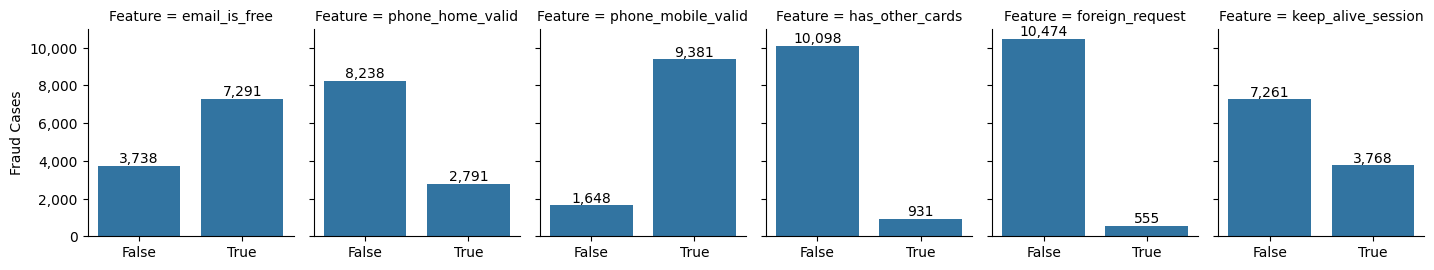

In [ ]:
get_fraud_count_in_facetgrid(list_bool_fraud_counts)

The features **phone_mobile_valid**, **has_other_cards**, and **foreign_request** exhibit a significant contrast between their True and False values. I conduct further analysis using a Confusion Matrix.


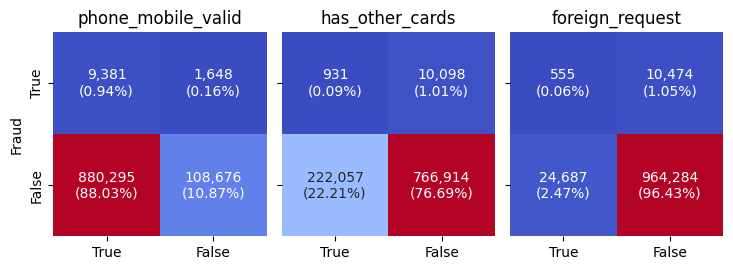

In [ ]:
# Only categorical features
feature_names = ["phone_mobile_valid", "has_other_cards", "foreign_request"]

conf_matrices = [confusion_matrix(y, X[feature_name]) for feature_name in feature_names]

conf_matrices_data = []
for i, mat in enumerate(conf_matrices):
    for row in range(mat.shape[0]):
        for col in range(mat.shape[1]):
            conf_matrices_data.append([feature_names[i], row, col, mat[row, col]])

conf_matrices_df = pd.DataFrame(conf_matrices_data, columns=[LABEL_FEATURE, LABEL_TRUE, LABEL_FALSE, LABEL_COUNT])

# Compute total count per feature
feature_totals_df = conf_matrices_df.groupby(LABEL_FEATURE)[LABEL_COUNT].sum()

# Add Cell Annotation column as percentage
conf_matrices_df[LABEL_CELL_ANNOTATION] = conf_matrices_df.apply(lambda row: f"{row[LABEL_COUNT]:,.0f}\n({(row[LABEL_COUNT] / feature_totals_df[row[LABEL_FEATURE]] * 100):.2f}%)", axis=1)


# Pivot the data and reverse both axes
def plot_heatmap(data, **kwargs):
    feature_name = data[LABEL_FEATURE].iloc[0]  # Extract feature name
    pivot_df = data.pivot(index=LABEL_TRUE, columns=LABEL_FALSE, values=LABEL_COUNT)

    # Reverse y-axis (so 1 is at the top) and x-axis (so 1 is on the left)
    pivot_df = pivot_df.iloc[::-1, ::-1]

    ax = sns.heatmap(pivot_df,
                     cmap=LABEL_HEATMAP_COOLWARM,
                     annot=data.pivot(index=LABEL_TRUE, columns=LABEL_FALSE, values=LABEL_CELL_ANNOTATION).iloc[::-1, ::-1].values,
                     cbar=False,
                     xticklabels=[LABEL_TRUE, LABEL_FALSE],
                     yticklabels=[LABEL_TRUE, LABEL_FALSE],
                     fmt="s")
    ax.set_title(feature_name)  # Set title per subplot

# Create a FacetGrid for multiple confusion matrices
g = sns.FacetGrid(conf_matrices_df, col=LABEL_FEATURE, col_wrap=5, height=3, aspect=0.8)
g.map_dataframe(plot_heatmap)
g.set(xlabel=None)
g.set(ylabel=LABEL_FRAUD)
plt.show()

The previous section displays only the bottom rows in each Confusion Matrix where the fraud flag is set to false, which does not provide any meaningful insights related to fraud detection.

Consequently, this demonstrates that comparing individual feature counts directly to fraudulent transaction counts does not effectively identify key influential features. Moreover, it fails to uncover the underlying relationships among features that contribute to fraudulent activity in a more complex manner.

I now analyse the categorical features with Confusion Matrices.

In [ ]:
def get_heatmap_for_categorical_feature(col_name: str) -> None:
  # First combine the target column and "col_name"
  df_combined = pd.concat([y, X[col_name]], axis=1)

  # Get the count matrix
  count_matrix = df_combined.groupby([LABEL_TARGET, col_name]).size().unstack(fill_value=0)

  # Currently, it looks something like this where fraud value of 1 (True) is positioned in the second row
  # payment_type      AA      AB      AC      AD   AE
  # fraud_bool
  # 0             256885  366385  247862  117551  288
  # 1               1364    4169    4209    1286    1

  # Swap the first and second rows, so that it aligns with the Confusion matrix style
  count_matrix = count_matrix.iloc[[1, 0]]

  # The first "sum()" only does for the columns separately, so give it another "sum()" for the entire DataFrame
  total_count = count_matrix.sum().sum()
  percent_data = count_matrix.map(lambda x: f"{x:,.0f}\n({x/total_count:.1%})")

  # Plot heatmap
  plt.figure(figsize=(6, 2))
  ax = sns.heatmap(count_matrix, annot=percent_data, fmt="", cmap=LABEL_HEATMAP_COOLWARM, linewidths=0.5, cbar=False, yticklabels=[LABEL_TRUE, LABEL_FALSE])

  plt.xlabel(col_name)
  plt.ylabel(LABEL_FRAUD)
  plt.show()

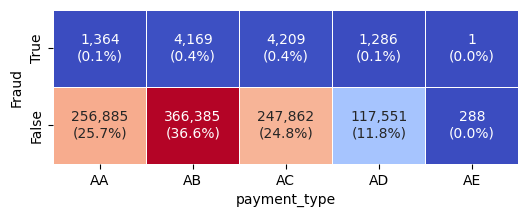

In [ ]:
get_heatmap_for_categorical_feature("payment_type")

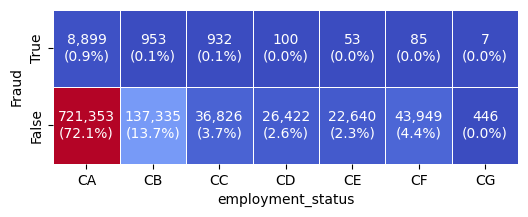

In [ ]:
get_heatmap_for_categorical_feature("employment_status")

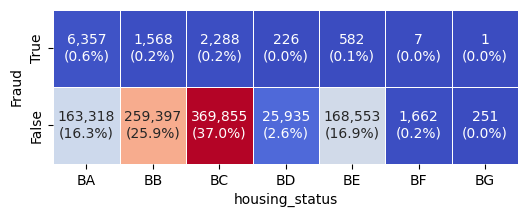

In [ ]:
get_heatmap_for_categorical_feature("housing_status")

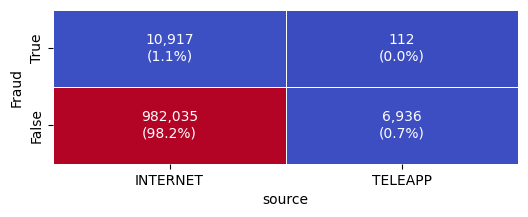

In [ ]:
get_heatmap_for_categorical_feature("source")

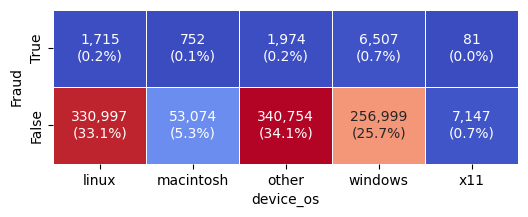

In [ ]:
get_heatmap_for_categorical_feature("device_os")

Similar to the previous binary feature heatmaps, no individual categorical feature emerges as a significant predictor of fraudulent transactions.

In [ ]:
def get_confusion_matrix(data: pd.DataFrame | np.ndarray, col_name: str) -> None:
  # With unsupervised machine learning, "data" comes in the form of np.ndarray, so convert it to DataFrame
  df = pd.DataFrame(data, columns=[col_name]) if isinstance(data, np.ndarray) else data

  # In the binary case like this, extract true positives, etc. as follows
  # Two sets of swappings are necessary TN <-> TP & FN <-> FP!
  # normal quadrants = {
  # "True Negative (TN)": cm[0][0],
  # "False Positive (FP)": cm[0][1],
  # "False Negative (FN)": cm[1][0],
  # "True Positive (TP)": cm[1][1]
  # }

  # binary quadrants = {
  # "True Negative (TN)": cm[1][1],
  # "False Positive (FP)": cm[1][0],
  # "False Negative (FN)": cm[0][1],
  # "True Positive (TP)": cm[0][0]
  # }

  tn, fp, fn, tp = confusion_matrix(y, df[col_name]).ravel()

  # "confusion_matrix" = E.g. [np.int64(9381), np.int64(880295), np.int64(1648), np.int64(108676)]
  # Cconvert "np.int64" to "int"
  cm_in_int = np.array(
                        [
                          [int(tp), int(fn)],
                          [int(fp), int(tn)],
                        ]
                      )

  flattened_cm_in_int = cm_in_int.flatten()
  total_count = np.sum(cm_in_int)

  group_counts = ["{0:,.0f}".format(value) for value in flattened_cm_in_int]
  group_percentages = ["{0:.2%}".format(value) for value in flattened_cm_in_int/total_count]
  group_counts = ["{0:,.0f}".format(value) for value in flattened_cm_in_int]
  group_percentages = ["{0:.2%}".format(value) for value in flattened_cm_in_int/total_count]
  labels = [f"{g1}\n({g2})" for g1, g2 in zip(group_counts,group_percentages)]

  # As of now, labels is a one-dimentional array i.e., [...]
  # Convert it to an array of arrays
  labels = np.asarray(labels).reshape(y.nunique(), df[col_name].nunique())
  plt.figure(figsize=(4, 2))
  heatmap = sns.heatmap(cm_in_int, annot=labels, fmt="", cbar=False, cmap=LABEL_HEATMAP_COOLWARM, xticklabels=[LABEL_TRUE, LABEL_FALSE], yticklabels=[LABEL_TRUE, LABEL_FALSE])

  # Apply the formatter to the colorbar
  colorbar = heatmap.collections[0].colorbar

  plt.xlabel(col_name)
  plt.ylabel(LABEL_FRAUD)
  plt.show()

In [ ]:
def get_precision_recall_f1_scores(arr_test: list | np.ndarray | pd.Series, arr_pred: list | np.ndarray | pd.Series) -> tuple:
  return (precision_score(arr_test, arr_pred), recall_score(arr_test, arr_pred), f1_score(arr_test, arr_pred))

In [ ]:
# Initialize an empty dataframe
# This stores the fraud hit counts by each method
df_method_ourlier_result = pd.DataFrame(columns=[LABEL_METHOD, LABEL_COUNT, LABEL_PRECISION, LABEL_RECALL, LABEL_F1SCORE], dtype=float)

#### 2. Density-based Method (Density-Based Spatial Clustering of Applications with Noise (DBSCAN))
---

In [ ]:
start_time = time.time()

# Density-Based Spatial Clustering of Applications with Noise
dbscan = DBSCAN(eps=1.5, min_samples=2)
labels = dbscan.fit_predict(X_standard_scaled)

# Mark outliers (DBSCAN labels outliers as -1)
dbscan_outliers = (labels == -1)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
dbscan_outlier_count = (y * dbscan_outliers == 1).sum()
precision, recall, f1 = get_precision_recall_f1_scores(y, dbscan_outliers)
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ["DBSCAN", dbscan_outlier_count, precision, recall, f1]

print(measure_duration(start_time, True))

Duration: 01h03m50s


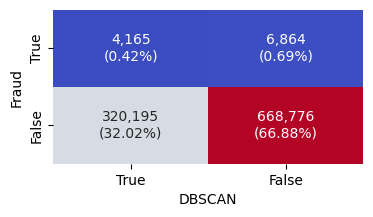

In [ ]:
get_confusion_matrix(dbscan_outliers, "DBSCAN")

#### 3. Probability-based Method (Gaussian Mixiture Model (GMM))
---

In [ ]:
start_time = time.time()

gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=RANDOM_STATE_NUM)
gmm.fit(X_standard_scaled)

# Compute probability scores
probs = gmm.predict_proba(X_standard_scaled).max(axis=1)

# Set threshold (low probability = outlier)
threshold = np.percentile(probs, 5)  # 5th percentile
gmm_outliers = (probs < threshold)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
gmm_outlier_count = (y * gmm_outliers == 1).sum()
precision, recall, f1 = get_precision_recall_f1_scores(y, gmm_outliers)
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ["GMM", gmm_outlier_count, precision, recall, f1]

print(measure_duration(start_time, True))

Duration: 00h00m17s


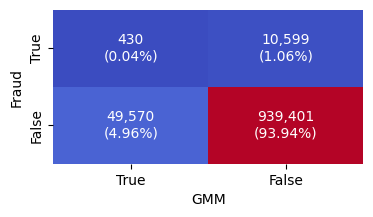

In [ ]:
get_confusion_matrix(gmm_outliers, "GMM")

#### 4. Distance-based Method (K-Nearest Neighbors (KNN))
---

In [ ]:
start_time = time.time()

# This process takes at least 1.5 hours and I choose "ball_tree" instead of "auto" for speed
# - **BallTree (`algorithm='ball_tree'`)**:
#   - Performs better in **high-dimensional spaces**.
#   - Uses a **metric-space approach**, making it efficient for Euclidean and other distance metrics.
#   - Generally faster than `kd_tree` when `dimensions > 20`.
# - **KDTree (`algorithm='kd_tree'`)**:
#   - Works best for **low-dimensional data** (typically <20 dimensions).
#   - Uses a **hyperplane-splitting approach**, which struggles in high-dimensional spaces.
#   - May be slower due to the curse of dimensionality.
nbrs = NearestNeighbors(n_neighbors=3, algorithm="ball_tree")
nbrs.fit(X_standard_scaled)
distances, indices = nbrs.kneighbors(X_standard_scaled)

# Compute the mean distance to k-nearest neighbors
mean_distances = distances.mean(axis=1)

# Set threshold as the 95th percentile
threshold = np.percentile(mean_distances, 95)

knn_outliers = (mean_distances > threshold)

# Count the number of rows where both "fraud_bool" and the derived outlier by the model MACTH, i.e., multiplication of both values in the row results in 1
knn_outlier_count = (y * knn_outliers == 1).sum()
precision, recall, f1 = get_precision_recall_f1_scores(y, knn_outliers)
df_method_ourlier_result.loc[len(df_method_ourlier_result)] = ["KNN", knn_outlier_count, precision, recall, f1]

print(measure_duration(start_time, True))

In [ ]:
get_confusion_matrix(knn_outliers, "KNN")

###Accuracy, Precision or Recall?
---
**Precision (Positive Predictive Value)**
- Precision tells you how **many of the positive predictions** made by your model are actually **correct**.
- It's especially important in cases where **false positives** (incorrectly labeling something as positive) have serious consequences.
- **Example**: In spam detection, high precision means that most emails marked as spam are indeed spam, minimizing the risk of wrongly filtering out important emails.

**Recall (Sensitivity or True Positive Rate)**
- Recall indicates how **many actual positive cases** your model correctly identified.
- It's crucial in scenarios where **false negatives** (failing to identify a positive case) can be costly.
- **Example**: In medical diagnosis, high recall ensures that most patients with a condition are correctly diagnosed, reducing the chances of missing a serious illness.

When analyzing bank account fraud using transaction data, the choice between focusing on recall or precision depends on the specific goals and risks involved.

- **Precision**: Measures how many flagged transactions are truly fraudulent. A high precision ensures fewer false alarms, meaning legitimate transactions aren't wrongly blocked.
- **Recall** (Sensitivity): Measures how well the model identifies fraudulent transactions. A high recall ensures that most fraudulent cases are caught, but it might also include false positives (legitimate transactions flagged as fraud).

Which one to prioritize?  
- If **missing fraudulent transactions** is riskier (e.g., fraud leads to significant financial loss), then **high recall** is crucial.
- If **false positives** disrupt customer experience (e.g., legitimate transactions get blocked), then **high precision** is more important.
- A balanced **F1-score** (harmonizing recall and precision) may be best for real-world fraud detection.

Typically, fraud detection leans toward **higher recall**, ensuring fraudsters don't slip through, but precision matters too to avoid customer frustration. Banks often use a combination with fine-tuned thresholds.

Simple explanation using apples and oranges can be found [here](https://www.youtube.com/watch?v=qWfzIYCvBqo).

In [ ]:
# Compare all the unsupervised models by Precision, Recall and F1-score
print(df_method_ourlier_result)

### So far outlier detection methods turn out to be uninformative. Now what?
---
Up to this point, I have **not** trained a single model using actual fraud labeling data. Now, it’s time to do exactly that and evaluate how these **supervised** learning models perform.

[The challenges of AML transaction monitoring](https://linkurious.com/transaction-monitoring-in-aml/#the-challenges-of-aml-transaction-monitoring) succinctly summarize the ever-evolving nature of this practice.  
> "Many AML transaction monitoring systems depend on static rules to flag potentially suspicious behavior. These systems do a good job of turning up known anomalies - but they don’t take context into account and often miss part of the picture.

> "These traditional rules-based monitoring systems also often generate **a high number of false positives** overwhelming investigators with alerts and making it challenging to distinguish genuine threats from noise."

> "At the same time, money launderers are becoming increasingly sophisticated in disguising their illicit activities. They adapt to the rules flagged by transaction monitoring to fly under the radar, leading to false negatives.This underscores the necessity for institutions to adopt more advanced and adaptive solutions."

Therefore, I firmly believe that a supervised learning method could provide deeper insights into the data and enhance the accuracy of fraud detection.

When working with a **large account fraud transaction dataset** that includes a labeled fraud feature, each supervised learning model approaches the problem in a unique way. Here's how each model would handle fraud detection:

**1️⃣ Logistic Regression**  
- **How It Works:** Logistic regression is a simple yet effective **binary classification model** that predicts the probability of fraud based on feature relationships.  
- **Strengths:**
  - Highly interpretable and provides **clear insights** into feature importance.
  - Works well with **balanced datasets**.
- **Challenges in Fraud Detection:**
  - Struggles with **imbalanced datasets** (fraud cases are often rare).
  - Assumes a **linear relationship**, which may not fully capture fraud patterns.

👉 Best for **initial risk assessment and feature significance analysis**.

### **2️⃣ Random Forest**  
- **How It Works:** A **bagging-based ensemble model** that trains multiple decision trees and averages their predictions.  
- **Strengths:**
  - Handles **imbalanced datasets well**.
  - Captures **non-linear relationships**, making it robust for fraud detection.
  - Provides **feature importance scores** to identify critical fraud-related features.
- **Challenges in Fraud Detection:**
  - Can be **computationally expensive** for very large datasets.
  - Requires **fine-tuning** to avoid overfitting.

👉 Best for **detecting hidden fraud patterns and ranking feature importance**.

### **3️⃣ Gradient Boosting (XGBoost)**  
- **How It Works:** A boosting model that builds trees sequentially, correcting previous errors to improve fraud detection accuracy.  
- **Strengths:**
  - Performs exceptionally well in **high-dimensional datasets** with complex relationships.
  - Works well with **imbalanced datasets** by weighting fraud cases properly.
  - Highly optimized for **speed and efficiency** in large datasets.
- **Challenges in Fraud Detection:**
  - More prone to **overfitting** if hyperparameters aren't tuned properly.
  - Requires **careful handling of categorical features**.

👉 Best for **highly accurate fraud classification in large, complex datasets**.

### **4️⃣ Support Vector Machines (SVM)**  
- **How It Works:** Finds an optimal **hyperplane** that separates fraudulent from non-fraudulent transactions.  
- **Strengths:**
  - Works well when fraud cases are **clearly separable**.
  - Effective in **small to medium-sized datasets**.
- **Challenges in Fraud Detection:**
  - **Not scalable** for large fraud transaction datasets.
  - Requires **kernel tuning** for non-linear fraud patterns.

👉 Best for **small fraud datasets with well-separated fraud cases**.

### **5️⃣ Neural Networks (Deep Learning)**  
- **How It Works:** Uses multiple layers to **learn complex fraud patterns** in transaction data.  
- **Strengths:**
  - Excellent for detecting **subtle fraud behaviors**.
  - Can learn fraud patterns **without explicit feature engineering**.
  - Works well with **massive transaction datasets**.
- **Challenges in Fraud Detection:**
  - Requires **large labeled fraud data** for effective training.
  - More difficult to **interpret model decisions**.

👉 Best for **large-scale fraud detection where deep learning can uncover hidden anomalies**.

Choosing the right encoding method agaist categorical features depends on the nature of your categorical data and the machine learning model used:

1. **One-Hot Encoding**  
   ✅ Use when:
   - The categorical feature has a small number of unique values.
   - There’s no inherent order in the categories.
   - You’re using models that don’t assume numeric relationships, such as decision trees or neural networks.  

   ❌ Avoid when:
   - The number of unique categories is large (leads to high-dimensional data).
   - The model struggles with sparsity (e.g., linear regression).

2. **Label Encoding**  
   ✅ Use when:
   - The categorical values have a meaningful order (ordinal features).
   - You’re using models that can interpret categorical relationships, like tree-based models (random forests, XGBoost).  

   ❌ Avoid when:
   - The categories don’t have an ordinal relationship, as numerical labels may introduce unintended biases.

3. **Ordinal Encoding**  
   ✅ Use when:
   - Your categories have a natural ranking (e.g., "Low," "Medium," "High").
   - You want to preserve order relationships in linear models.  

   ❌ Avoid when:
   - The categorical data is purely nominal (no ranking exists).

4. **Binary Encoding**  
   ✅ Use when:
   - You have high-cardinality categorical features (many unique values).
   - You want to reduce dimensionality compared to one-hot encoding.  

   ❌ Avoid when:
   - Your model struggles with complex transformations.

5. **Target Encoding**  
   ✅ Use when:
   - The categorical feature is strongly correlated with the target variable.
   - You're working with regression problems or need to optimize predictive power.  

   ❌ Avoid when:
   - You have small datasets, as this can lead to overfitting.
   - There's a risk of data leakage if applied incorrectly.

In [25]:
# https://scikit-learn.org/stable/modules/preprocessing.html

X_categorical_values_encoded = X.copy()

# Apply One-Hot Encoding as the cardinality of each categorical features are small.
X_categorical_values_encoded = pd.get_dummies(X_categorical_values_encoded, columns=X_categorical_values_encoded.select_dtypes(include=[LABEL_OBJECT]).columns)

X_standard_scaled_all_features = pd.DataFrame(scaler.fit_transform(X_categorical_values_encoded), columns=X_categorical_values_encoded.columns)

I first examine the linear correlations between the features.

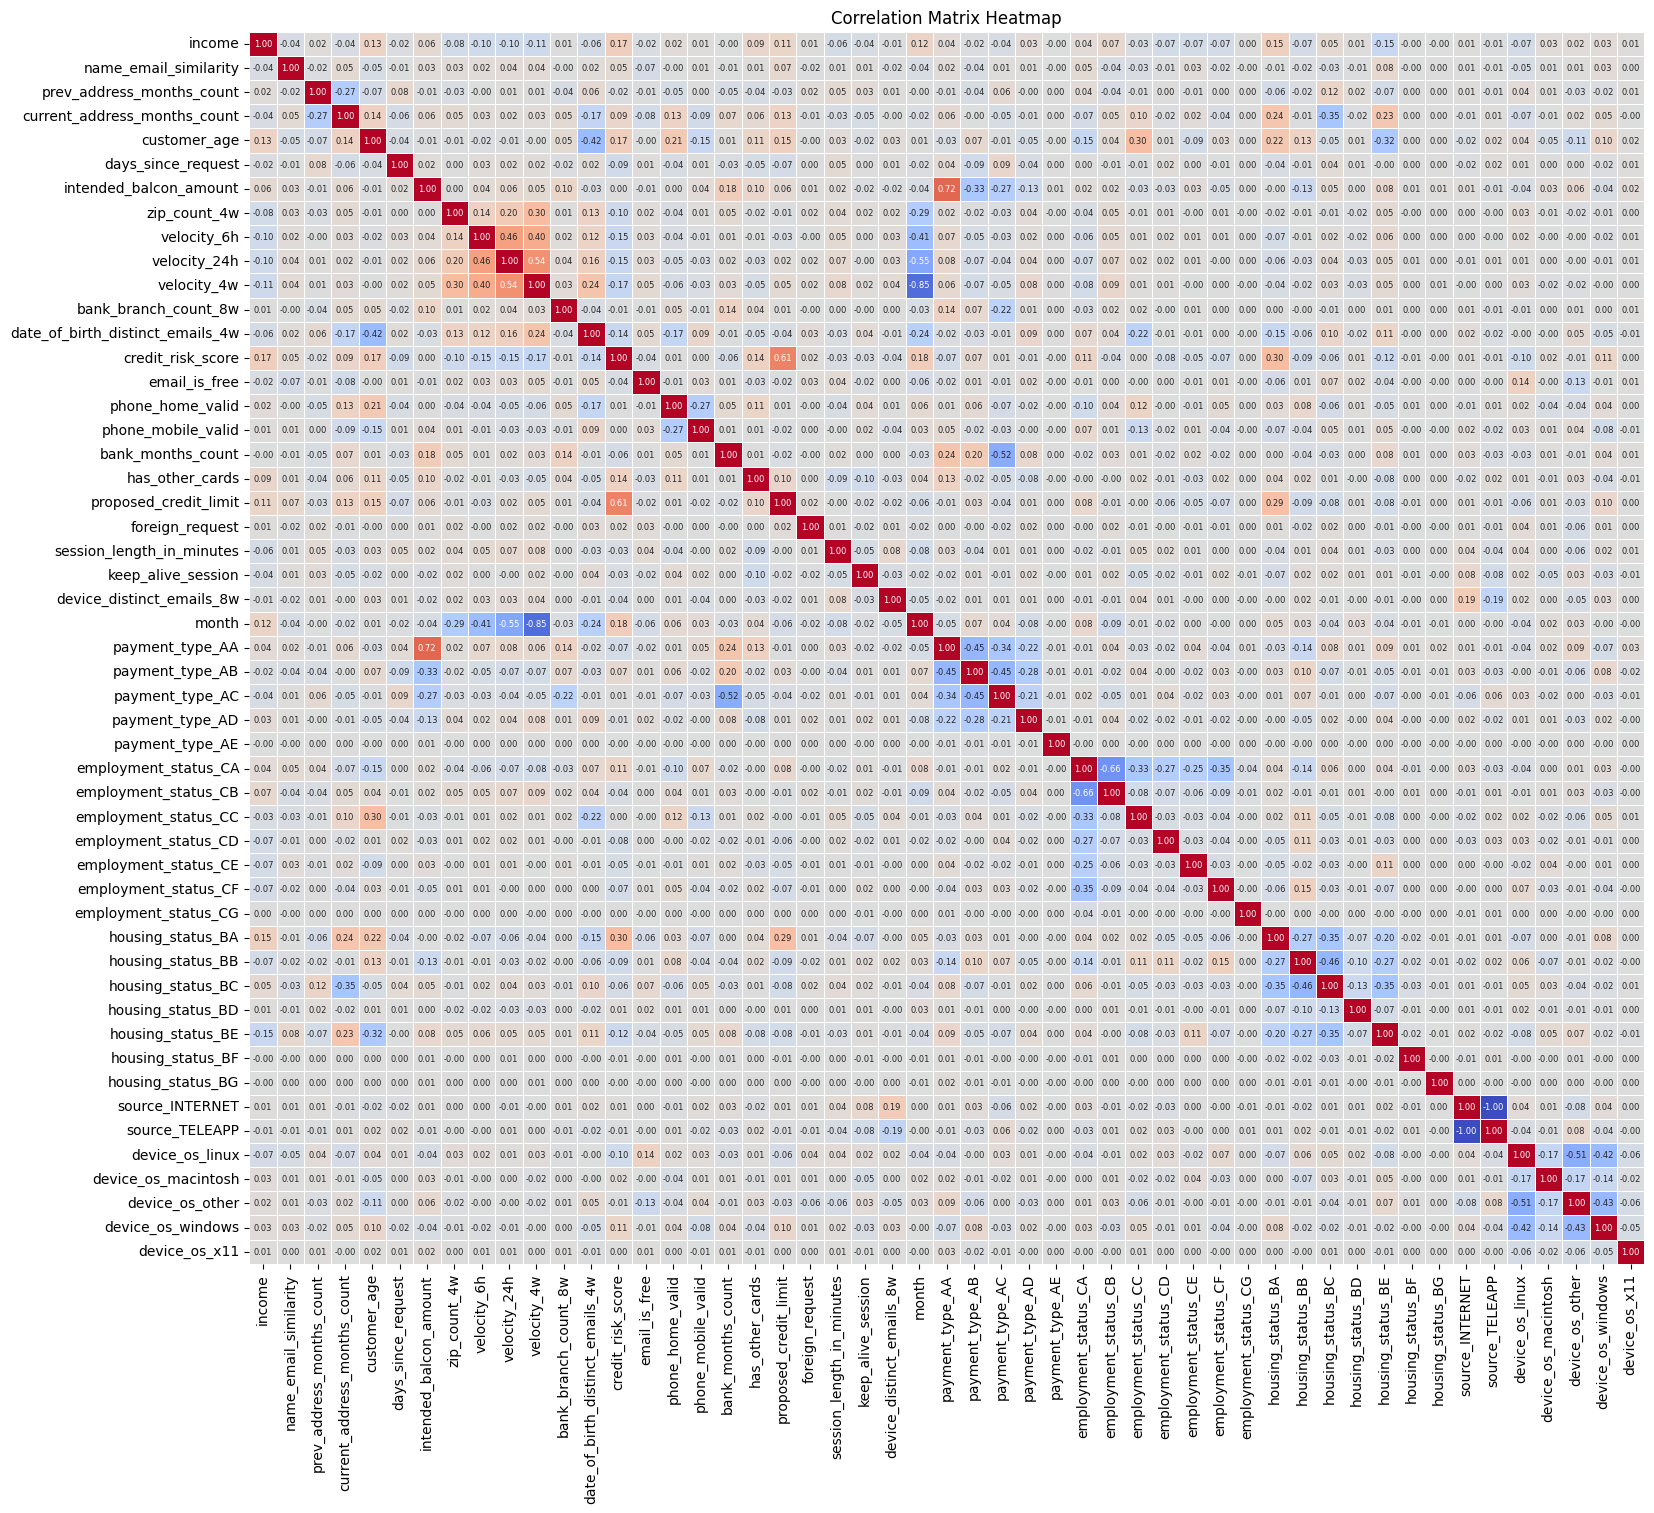

In [25]:
plt.figure(figsize=(18, 16))

# The defaulgt annot_kws's size is 10
sns.heatmap(X_standard_scaled_all_features.corr(method="pearson"), annot=True, annot_kws={"size": 6}, cbar=False, cmap=LABEL_HEATMAP_COOLWARM, fmt=FORMAT_DECIMALS, linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

Virtually no single feature exhibits a strong linear correlation with one another (No.1 above).

**Exploring Different Evaluation [Metrices](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)**  
While `accuracy` is common, it's often **not ideal for imbalanced datasets**. Better alternatives include:

1. **Precision (`precision_score`)** – Measures how many predicted positives are actual positives.
2. **Recall (`recall_score`)** – Measures how well the model identifies all actual positives.
3. **F1-score (`f1_score`)** – The harmonic mean of precision and recall (**particularly useful** for imbalanced data).
4. **ROC-AUC (`roc_auc_score`)** – Evaluates classifier performance across different thresholds.
5. **PR-AUC (`average_precision_score`)** – Focuses on precision-recall trade-off.

Epoch 1/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9890 - loss: 0.0534
Epoch 2/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9890 - loss: 0.0473
Epoch 3/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.9890 - loss: 0.0468
Epoch 4/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9890 - loss: 0.0465
Epoch 5/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.9890 - loss: 0.0464
Epoch 6/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.9890 - loss: 0.0462
Epoch 7/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - accuracy: 0.9891 - loss: 0.0461
Epoch 8/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9891 - loss: 0.0460
Epoch 9/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9891 - loss: 0.0459
Epoch 10/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9891 - loss: 0.0458
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

Model Performance Metrics:

                 

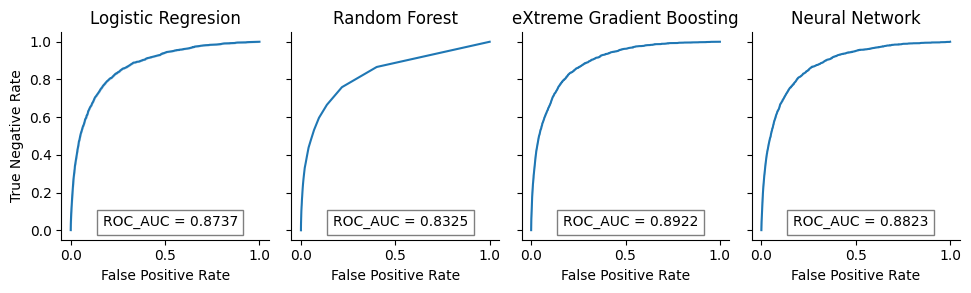

In [26]:
tf.random.set_seed(RANDOM_STATE_NUM) # Set randomness globally

X_train, X_test, y_train, y_test = train_test_split(X_standard_scaled_all_features, y, test_size=TRAIN_TEST_SPLIT_SIZE, random_state=RANDOM_STATE_NUM)

# Define models
models = {
            LABEL_LOGISTIC_REGRESSION: LogisticRegression(random_state=RANDOM_STATE_NUM),
            LABEL_RANDOM_FOREST: RandomForestClassifier(random_state=RANDOM_STATE_NUM),
            LABEL_XGB_BOOST: XGBClassifier(random_state=RANDOM_STATE_NUM)
        }

roc_data = []
metrics_data = []

for model_name, model in models.items():
    start_time = time.time()

    model.fit(X_train, y_train)

    y_probs = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    for i in range(len(fpr)):
        roc_data.append([model_name, fpr[i], tpr[i], roc_auc])

    y_pred = model.predict(X_test)
    precision_, recall_, f1_score_, _ = precision_recall_fscore_support(y_test, y_pred, average=LABEL_BINARY)

    metrics_data.append([model_name, precision_, recall_, f1_score_, roc_auc, measure_duration(start_time)])

# Add TensorFlow Neural Network separately
start_time = time.time()

inputs = keras.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(32, activation="relu")(inputs)
x = keras.layers.Dense(16, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
nn_model = keras.Model(inputs=inputs, outputs=outputs)

nn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Small datasets: Usually need more epochs (e.g., 50–200) to extract enough patterns.
# Large datasets: Fewer epochs (e.g., 10–50) often suffice since there's plenty of data to generalize from.
nn_model.fit(X_train, y_train, epochs=10, verbose=1)

y_probs_nn = nn_model.predict(X_test).flatten()

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_probs_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

for i in range(len(fpr_nn)):
    roc_data.append([LABEL_NEURAL_NETWORK, fpr_nn[i], tpr_nn[i], roc_auc_nn])

y_pred_nn = (y_probs_nn >= 0.5).astype(int)  # Convert probabilities to binary labels
precision_nn, recall_nn, f1_score_nn, _ = precision_recall_fscore_support(y_test, y_pred_nn, average=LABEL_BINARY)

metrics_data.append([LABEL_NEURAL_NETWORK, roc_auc_nn, recall_nn, f1_score_nn, precision_nn, measure_duration(start_time)])

df_roc = pd.DataFrame(roc_data, columns=[LABEL_MODEL, LABEL_FALSE_POSITIVE, LABEL_TRUE_POSITIVE, LABEL_ROC_AUC])
df_supervised_method_result = pd.DataFrame(metrics_data, columns=[LABEL_MODEL, LABEL_PRECISION, LABEL_RECALL, LABEL_F1SCORE, LABEL_ROC_AUC, LABEL_DURATION])

g = sns.FacetGrid(df_roc, col=LABEL_MODEL, col_wrap=6, height=3, aspect=0.8)
g.map_dataframe(sns.lineplot, x=LABEL_FALSE_POSITIVE, y=LABEL_TRUE_POSITIVE)

# Add AUC as subplot titles
for ax, title in zip(g.axes.flat, df_roc[LABEL_MODEL].unique()):
    auc_value = df_roc[df_roc[LABEL_MODEL] == title][LABEL_ROC_AUC].values
    ax.set_title(title)

    if len(auc_value) > 0:
        # ax.set_label(f"{LABEL_ROC_AUC} = {auc_value[0]:.4f}")
        # ax.legend(labels=f"{LABEL_ROC_AUC} = {auc_value[0]:.4f}", loc="lower right")
        ax.text(0.85, 0.05, f"{LABEL_ROC_AUC} = {auc_value[0]:.4f}",
                transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
                horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

print(f"\nModel Performance Metrics:\n")
print(df_supervised_method_result)

plt.show()

### `random_state` parameter  
---
Once the **random_state** parameter for **train-test splitting** is set, all models trained on the resulting datasets will receive the same data distribution. However, setting `random_state` inside individual models (e.g., `RandomForestClassifier(random_state=42)`) can still matter for **repeatability** in certain cases:

**Why Setting `random_state` in Models Can Be Important**
1. **Ensures Consistency in Stochastic Algorithms:**  
   - Models like **Random Forest, Gradient Boosting, and SVM** involve **random sampling** or **bootstrapping**, meaning results can slightly vary across runs.
   - By setting `random_state`, we ensure they generate **consistent trees and decision paths** across runs.

2. **Reproducibility for Comparisons:**  
   - If you're **comparing multiple models**, especially those with a **random component**, setting `random_state` helps maintain **fairness** in evaluation.
   - Example: A **random forest** built on the same training set but with different seeds could yield different feature importances, impacting consistency in interpretation.

3. **Neural Networks & Deep Learning Exception:**  
   - For models like **TensorFlow/Keras Neural Networks**, setting `random_state` in `train_test_split` is **not enough** because these models rely on **random weight initializations** and stochastic optimization.
   - You typically also set randomness globally in TensorFlow using:  
     ```python
     import tensorflow as tf
     tf.random.set_seed(42)
     ```
   - This ensures **consistent initialization and training behavior** across runs.

**Do You Need to Set `random_state` for All Models?**  
✔ If using **pure deterministic models** (e.g., Logistic Regression), setting `random_state` is **optional**.  
✔ If using **ensemble models** or stochastic algorithms (e.g., RandomForest, SVM), setting `random_state` **inside the model** is highly recommended.  
✔ If using **neural networks**, additional randomness controls like `tf.random.set_seed()` should be used.  

So, while it’s **not strictly necessary**, applying `random_state` consistently ensures reliable comparisons and reproducibility—especially when sharing results or debugging models!

### `SVC()`  
---  
I highlight Support Vector Classification (SVC) and One-Class Support Vector Machine (One-Class SVM), as I mistakenly referred to the former by the latter's name.

🔍 **Key Differences**

| Feature              | `SVC()`                         | `OneClassSVM()`                    |
|----------------------|----------------------------------|------------------------------------|
| **Type**             | Supervised                      | Unsupervised                       |
| **Goal**             | Classify into known categories  | Detect outliers or novelties       |
| **Labels Required**  | Yes (`y`)                       | No                                 |
| **Output**           | Class labels                    | +1 (inlier), -1 (outlier)          |
| **Common Use Case**  | Email classification            | Fraud detection                    |  
    
Even after realizing this, I had to abandon the SVC in the later section, as its model fitting with the default `kernel='rbf'` failed to complete after seven hours of computation.

Here’s a detailed comparison table of the **kernel types available in `sklearn.svm.SVC()`**, including their best use cases, pros, cons, and relative model fitting speed:

| **Kernel**     | **Best For**                                                                 | **Pros**                                                                 | **Cons**                                                                 | **Model Fitting Speed** |
|----------------|------------------------------------------------------------------------------|--------------------------------------------------------------------------|--------------------------------------------------------------------------|--------------------------|
| `linear`       | Linearly separable data or high-dimensional sparse data (e.g., text)         | - Fast training<br>- Simple and interpretable<br>- Works well with large feature sets | - Poor performance on non-linear data                                     | ⭐⭐⭐⭐☆ (Fast)            |
| `rbf` (default)| Most general-purpose kernel; non-linear problems                             | - Handles complex relationships<br>- Few hyperparameters                 | - Slower on large datasets<br>- Requires tuning `gamma` and `C`          | ⭐⭐☆☆☆ (Slow)            |
| `poly`         | Data with polynomial relationships                                           | - Captures interactions between features<br>- Flexible                   | - Sensitive to degree<br>- Can overfit<br>- Slower than linear           | ⭐⭐☆☆☆ (Slow)            |
| `sigmoid`      | Similar to neural networks (rarely used in practice)                         | - Can mimic neural network behavior                                      | - Not widely used<br>- Often underperforms<br>- Sensitive to parameters  | ⭐⭐☆☆☆ (Slow)            |
| `precomputed`  | When you have a custom kernel matrix already computed                        | - Allows custom similarity measures                                      | - Requires manual kernel computation<br>- Not scalable                   | ⭐☆☆☆☆ (Depends)         |



I could have applied any of the following strategies:

⚡ 1. **Use a Linear Kernel When Possible**
- The **RBF** and **polynomial** kernels are powerful but computationally expensive.
- If your data is linearly separable or close to it, use:
  ```python
  SVC(kernel='linear')
  ```

⚡ 2. **Use `LinearSVC` Instead of `SVC(kernel='linear')`**
- `LinearSVC` is optimized for linear problems and **much faster** than `SVC(kernel='linear')` for large datasets.
  ```python
  from sklearn.svm import LinearSVC
  model = LinearSVC()
  ```
  
⚡ 3. **Use Approximate or Stochastic Methods**
- For very large datasets, consider **SGDClassifier** with hinge loss (SVM-like):
  ```python
  from sklearn.linear_model import SGDClassifier
  model = SGDClassifier(loss='hinge')
  ```

⚡ 4. **Reduce Dataset Size**
- **Subsample** your training data if it's very large.
- Use **stratified sampling** to maintain class balance.

⚡ 5. **Dimensionality Reduction**
- Apply **PCA**, **feature selection**, or **L1 regularization** to reduce the number of features.
  ```python
  from sklearn.decomposition import PCA
  X_reduced = PCA(n_components=50).fit_transform(X)
  ```

⚡ 6. **Tune Hyperparameters Efficiently**
- Use **randomized search** instead of grid search for faster hyperparameter tuning:
  ```python
  from sklearn.model_selection import RandomizedSearchCV
  ```

Numbers 1 through 3 are effective only when the data is linearly separable—meaning a straight line can clearly divide the classes. However, given the significant noise and outliers observed in this high-dimensional dataset, as indicated by the Standard Scaler earlier, I find this unlikely.

Regarding No. 4, I strongly prefer retaining as much of the original dataset as possible to enhance predictive performance, as a larger dataset generally provides deeper insights.

While I address No. 5 shortly, No. 6 should be considered only after selecting the optimal model.

### Feature Selection (a.k.a Dimentionality Reduction)
---
Whether supervised or unsupervised, the models above all struggle to predict fraud effectively. This is not surprising, as I strongly believe the dataset’s 51 features make it overly complex—even for advanced machine learning techniques.

However, it's important to recognize the value of human expertise, known as domain knowledge, in manually selecting meaningful features that machine learning alone cannot identify. While human insight plays a crucial role, algorithm-driven selection helps streamline the feature set, reducing redundancy and preventing overfitting while retaining critical information.

Feature selection in unsupervised learning is challenging since there are no labeled outcomes to guide the process. Alas, there are several effective techniques to identify relevant features. Here are some popular methods:

**1. Principal Component Analysis (PCA)**  
- **Purpose:** Reduces dimensionality by transforming features into a set of uncorrelated components.
- **How it Works:** Identifies the directions of maximum variance in the data, helping eliminate redundant features.

**2. Autoencoders**  
- **Purpose:** Neural network-based feature extraction and selection.
- **How it Works:** Encodes and reconstructs data, retaining only the most informative features while filtering out noise.

**3. Variance Thresholding**  
- **Purpose:** Removes low-variance features that are unlikely to be useful.
- **How it Works:** If a feature does not vary much across samples, it is likely redundant.

**4. Mutual Information-Based Methods**  
- **Purpose:** Measures how much information a feature provides about other features.
- **How it Works:** Evaluates dependencies between features without relying on labels.

**5. Clustering-Based Methods (e.g., k-means, hierarchical clustering)**  
- **Purpose:** Groups similar data points and selects representative features.
- **How it Works:** Identifies features that contribute most to cluster formation.

**6. L1 Regularization (Lasso Regression for Unsupervised Learning)**  
- **Purpose:** Shrinks feature weights, eliminating less important ones.
- **How it Works:** Uses sparsity constraints to retain only the most relevant features.

**7. Embedded Methods (e.g., Feature Importance from Random Forests)**  
- **Purpose:** Some unsupervised models can internally rank feature importance.
- **How it Works:** Decision trees or ensemble methods can be adapted to rank features based on how they contribute to clustering or anomaly detection.

On the other hand, a feature selection method using labeled data helps improve model performance, reduces overfitting, and speeds up computation.

Here are some widely used **supervised** feature selection methods:

**1. Filter Methods** (Based on Statistical Properties)
These methods evaluate features independently of any model, using statistical measures.
- **Correlation-based selection:** Identifies features that have strong correlations with the target variable.
- **Chi-Square test:** Used for categorical data to determine feature relevance.
- **Mutual Information (MI):** Measures how much information a feature provides about the target variable.
- **Variance Threshold:** Removes features with low variance, assuming they contribute little to predictions.

**2. Wrapper Methods** (Model-Based Selection)
Wrapper methods train and evaluate the model multiple times to determine the best feature set.
- **Recursive Feature Elimination (RFE):** Iteratively removes less important features based on model performance.
- **Forward Selection:** Starts with no features and adds the most significant ones step by step.
- **Backward Elimination:** Starts with all features and removes the least significant ones iteratively.

**3. Embedded Methods** (Built-in Feature Selection During Training)
These methods integrate feature selection directly into the learning process.
- **Lasso (L1 Regularization):** Shrinks less important feature coefficients to zero, effectively eliminating them.
- **Decision Tree Feature Importance:** Uses tree-based models (e.g., Random Forest, XGBoost) to rank features based on their contribution.
- **Elastic Net:** A combination of Lasso (L1) and Ridge (L2) regularization to balance feature selection and stability.

**4. Hybrid Methods** (Combining Multiple Approaches)
Some approaches combine filter and wrapper methods to optimize feature selection.
- **Feature Selection using Genetic Algorithms:** Uses evolutionary techniques to iteratively refine feature selection.
- **SHAP (Shapley Additive Explanations):** Evaluates feature impact on predictions using cooperative game theory principles.

### Mutual Information
---
This can be quite useful in a supervised binary classification setting. It helps identify the most relevant features by measuring the amount of information a given feature shares with the target variable. Here’s why it’s valuable:

- **Captures Non-Linear Dependencies**: Unlike correlation-based methods, mutual information can detect both linear and non-linear relationships between features and the target.
- **Improves Model Efficiency**: By selecting only the most informative features, it reduces dimensionality, speeds up training, and enhances generalization.
- **Handles Mixed Data Types**: Mutual information works for categorical and continuous data alike, making it versatile across different datasets.

However, it does have limitations:
- **Computational Cost**: Estimating mutual information can be computationally expensive, especially with large datasets.
- **Feature Redundancy**: If multiple features provide similar information, mutual information might not effectively filter them out.

In practice, mutual information is often combined with other techniques—like recursive feature elimination or regularization-based selection—to get the best results.

 I now build a new model by implementing **Mutual Information, Recursive Feature Elimination, and XGBClassifier** (the best supervised learning model based on its F1-score). This can be a powerful way to refine my feature selection for a binary classification model.  

**Summary**
1. Mutual Information **eliminates irrelevant features** based on information gain.
2. Recursive Feature Elimination **removes redundant features** by iteratively selecting the best subset.
3. The final model trains only on the most meaningful features.

In [ ]:
start_time = time.time()

mi_scores = mutual_info_classif(X_categorical_values_encoded, y, random_state=RANDOM_STATE_NUM)
mi_series = pd.Series(mi_scores, index=X_categorical_values_encoded.columns).sort_values(ascending=False)

# Set a threshold and select top features
mi_threshold = 0.01  # Adjust as needed
selected_features = mi_series[mi_series > mi_threshold].index
X_categorical_values_encoded_selected = X_categorical_values_encoded[selected_features]

print(measure_duration(start_time, True))
print(f"\nSelected Features from Mutual Information:\n{selected_features}")

Duration: 00h09m53s

Selected Features from Mutual Information:
Index(['source_INTERNET', 'device_distinct_emails_8w', 'employment_status_CA',
       'phone_mobile_valid', 'keep_alive_session', 'email_is_free',
       'phone_home_valid', 'housing_status_BC', 'payment_type_AB',
       'device_os_other', 'device_os_linux', 'customer_age',
       'proposed_credit_limit', 'device_os_windows', 'housing_status_BB',
       'payment_type_AA', 'payment_type_AC', 'income', 'has_other_cards',
       'month', 'housing_status_BA', 'housing_status_BE', 'bank_months_count',
       'date_of_birth_distinct_emails_4w', 'employment_status_CB'],
      dtype='object')


In [ ]:
# Perform RFE with a chosen number of features on the best model i.e., XGBClassifier
# n_features_to_select: default=None The number of features to select. If None, half of the features are selected. If integer, the parameter is the absolute number of features to select.
rfe = RFE(estimator=XGBClassifier(random_state=RANDOM_STATE_NUM))

X_rfe_selected = rfe.fit_transform(X_categorical_values_encoded_selected, y)

# Get final feature names
final_selected_features = X_categorical_values_encoded_selected.columns[rfe.support_]
print(f"Final Selected Features after RFE:\n{final_selected_features}")

Final Selected Features after RFE:
Index(['device_distinct_emails_8w', 'keep_alive_session', 'email_is_free',
       'phone_home_valid', 'customer_age', 'proposed_credit_limit',
       'device_os_windows', 'payment_type_AA', 'payment_type_AC',
       'has_other_cards', 'housing_status_BA', 'employment_status_CB'],
      dtype='object')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical_values_encoded_selected[final_selected_features], y, test_size=TRAIN_TEST_SPLIT_SIZE, random_state=RANDOM_STATE_NUM)

xgb_classifier_mi_rfe_model = XGBClassifier(random_state=RANDOM_STATE_NUM)

start_time = time.time()

xgb_classifier_mi_rfe_model.fit(X_train, y_train)

y_probs = xgb_classifier_mi_rfe_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

y_pred = xgb_classifier_mi_rfe_model.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=LABEL_BINARY)

# precision, recall, f1 = get_precision_recall_f1_scores(y_test, y_pred)
df_supervised_method_result.loc[len(df_supervised_method_result)] = ["MI + RFE + XGB", precision, recall, f1_score, roc_auc, measure_duration(start_time)]

print(df_supervised_method_result)

                       Model  Precision    Recall  F1-score   ROC_AUC  \
0        Logistic Regression   0.594595  0.010431  0.020503  0.873745   
1              Random Forest   0.666667  0.001897  0.003783  0.832496   
2  eXtreme Gradient Boosting   0.426778  0.048364  0.086882  0.892229   
3             Neural Network   0.878238  0.018966  0.036513  0.487805   
4             MI + RFE + XGB   0.452381  0.009009  0.017666  0.851155   

    Duration  
0  00h00m03s  
1  00h07m55s  
2  00h00m24s  
3  00h13m10s  
4  00h00m26s  


That new model is no way better than any others. I believe careful fine-tuning is needed to achieve a superior model.

By the way, achieving both **high precision** and **high recall** in a supervised model is challenging because they typically have an **inverse relationship**—improving one often worsens the other. However, there are strategies to **balance both** effectively:

1. **Optimize the Decision Threshold** – Adjusting the classification threshold can help tune precision vs. recall based on your specific needs.

2. **Use an Ensemble Model** – Combining multiple models (e.g., bagging or boosting) can help improve both metrics.

3. **Fine-Tune Feature Engineering** – Selecting the most relevant features and reducing noise improves both precision and recall.

4. **Adjust Class Weights** – In imbalanced datasets, tweaking class weights can help the model focus appropriately.

5. **Use Precision-Recall Curves** – Rather than relying on accuracy, optimizing based on PR curves ensures a better trade-off.

6. **Incorporate Domain Knowledge** – Tailor preprocessing and post-processing techniques to fit the nature of the data.

### Further Considerations
---

####1. Imbalanced Dataset
An **imbalanced dataset** is a dataset where the distribution of classes is **not equal**. This typically occurs in classification problems where one class has significantly more samples than another.

In our case, only a small percentage of transactions are fraudulent, while the majority are legitimate.

**Challenges of Imbalanced Datasets:**  
- 🚫 Bias in models – Machine learning models tend to favor the majority class.  
- 🚫 Poor predictive performance – Standard accuracy metrics can be misleading because predicting only the majority class may still yield high accuracy.  
- 🚫 Harder to detect rare cases – The model struggles to learn patterns in the minority class.  

**Solutions for Handling Imbalanced Datasets:**  
✅ **Resampling Techniques:**
   - Oversampling (Duplicate minority class samples)
   - Undersampling (Reduce majority class samples)
   - Synthetic Sampling (SMOTE) (Generate artificial data points)

✅ **Use Better Metrics:**  
   - Precision, Recall, F1-score
   - ROC-AUC & Precision-Recall curves

✅ **Change Model Strategy:**  
   - Use weighted loss functions to give more importance to the minority class.
   - Try **ensemble methods** like boosting (e.g., XGBoost) that handle imbalances well.

In [ ]:
print("This dataset includes " +
      format_thousands(df.shape[0]) +
      " rows, of which " +
      format_thousands((df[LABEL_TARGET] == 1).sum()) +
      " are marked as fraud.")

This dataset includes 1,000,000 rows, of which 11,029 are marked as fraud.


####2. Cross Validation (CV)  
- **Purpose:** Used to evaluate a model's performance and prevent overfitting.
- **Process:** Splits the dataset into multiple folds (e.g., k-fold cross-validation) to train and test the model on different subsets.
- **Outcome:** Provides a more reliable estimate of how the model performs on unseen data.  

Example (k-fold CV with 5 folds):  
1. Split data into 5 equal parts.
2. Train the model on 4 folds, validate on the remaining fold.
3. Repeat this 5 times, each time using a different fold for validation.
4. Average results across all folds for a more accurate performance estimate.

####3. Precision-Recall Curve
While the F1-score balances precision and recall, and ROC-AUC provides a general measure of classifier performance, the Precision-Recall Curve (PR-AUC) is particularly valuable for imbalanced datasets. This curve visualizes the trade-off between precision (the ratio of correctly identified positive cases to all predicted positives) and recall (the ratio of correctly identified positive cases to all actual positives). I encourage you to explore this concise explanation on  [thresholding](https://developers.google.com/machine-learning/crash-course/classification/thresholding).

####4. Scikit-learn's MLPClassifer vs Keras Tensorflow (Neural Notwork)
The MLPClassifier is a simple and user-friendly option for implementing neural networks, whereas Keras with TensorFlow offers extensive customization, making it well-suited for complex tasks.

Here is the code that implements all the four considerations.

Cross-Validation Comparison Table:
                           Threshold  Precision    Recall  F1-score  \
Random Forest               0.240000   0.111704  0.309753  0.164196   
Logistic Regresion          0.919149   0.166026  0.285650  0.209997   
eXtreme Gradient Boosting   0.181347   0.183327  0.273655  0.219564   
Neural Network              0.927970   0.126015  0.200000  0.154613   

                           Avg Precision  
Random Forest                   0.082592  
Logistic Regresion              0.133832  
eXtreme Gradient Boosting       0.140661  
Neural Network                  0.077348  


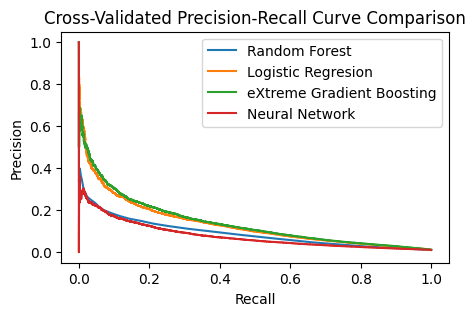

In [27]:
# 1.
# LogisticRegression's max_iter with 25, 50, 100 (default) and 200 all give the following warning.
# /usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
# STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.
# Increase the number of iterations (max_iter) or scale the data as shown in:
#     https://scikit-learn.org/stable/modules/preprocessing.html
# Please also refer to the documentation for alternative solver options:
#     https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
#   n_iter_i = _check_optimize_result(

# 2.
# MLPClassifier's max_iter is increased to 500 because 50, 100 and 200 (default) all gives the following warning
# /usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50/100/200) reached and the optimization hasn't converged yet.
#  warnings.warn(
models = {
    LABEL_RANDOM_FOREST: RandomForestClassifier(n_estimators=25, class_weight="balanced", random_state=RANDOM_STATE_NUM),
    LABEL_LOGISTIC_REGRESSION: LogisticRegression(max_iter=200, class_weight="balanced", random_state=RANDOM_STATE_NUM),
    LABEL_XGB_BOOST: XGBClassifier(random_state=RANDOM_STATE_NUM),
    LABEL_NEURAL_NETWORK: MLPClassifier(max_iter=500, random_state=RANDOM_STATE_NUM)
}

# -----------------------
# Cross-Validation Setup
# -----------------------
# Use 3-fold stratified cross validation, instead of 5-fold for speed
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE_NUM)

# Dictionaries to store cross validation results and precision-recall curves.
cv_results = {}
pr_curves = {}

for name, model in models.items():
    # Build a pipeline that first applies SMOTE, then fits the classifier.
    pipeline = Pipeline([
        ("smote", SMOTE(random_state=RANDOM_STATE_NUM)),
        ("clf", model)
    ])

    # Obtain out-of-fold probability estimates for the positive class via cross validation.
    # cross_val_predict ensures that each prediction is made on a fold where that sample was not seen in training.
    y_cv_probas = cross_val_predict(pipeline, X_train, y_train, cv=cv, method="predict_proba")[:, 1]

    # Compute the precision-recall curve based on the aggregated predictions.
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_train, y_cv_probas)

    # Note: precision and recall arrays have one extra element than thresholds.
    # We compute F1-scores for threshold candidates using the remaining elements.
    # Adding a very small value (1e-8) ensures numerical stability.
    f1_scores = 2 * (precision_vals[1:] * recall_vals[1:]) / (precision_vals[1:] + recall_vals[1:] + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    # Apply the chosen threshold to convert probabilities to binary predictions.
    y_cv_pred = (y_cv_probas >= best_threshold).astype(int)

    # Compute evaluation metrics on the cross validated (aggregated) predictions.
    prec_value = precision_score(y_train, y_cv_pred)
    rec_value = recall_score(y_train, y_cv_pred)

    f1_val = f1_score(y_train, y_cv_pred)
    avg_prec_val = average_precision_score(y_train, y_cv_probas)

    cv_results[name] = {
        "Threshold": best_threshold,
        LABEL_PRECISION: prec_value,
        LABEL_RECALL: rec_value,
        LABEL_F1SCORE: f1_val,
        "Avg Precision": avg_prec_val
    }

    # Save the precision-recall curve data for plotting.
    pr_curves[name] = (recall_vals, precision_vals)

# -----------------------
# Display Cross Validation Comparison Table
# -----------------------
results_df = pd.DataFrame(cv_results).T
print("Cross-Validation Comparison Table:")
print(results_df)

# -----------------------
# Plot Aggregated Precision-Recall Curves for All Models
# -----------------------
plt.figure(figsize=(5, 3))
for name, (recall_curve, precision_curve) in pr_curves.items():
    plt.plot(recall_curve, precision_curve, label=name)
plt.xlabel(LABEL_RECALL)
plt.ylabel(LABEL_PRECISION)
plt.title("Cross-Validated Precision-Recall Curve Comparison")
plt.legend()
plt.show()

# -----------------------
# Final Evaluation on a Hold-Out Test Set
# -----------------------
# Train each pipeline on the entire training set and evaluate on the independent test set.
# final_results = {}
# for name, model in models.items():
#     pipeline = Pipeline([
#         ("smote", SMOTE(random_state=42)),
#         ("clf", model)
#     ])
#     pipeline.fit(X_train, y_train)
#     y_test_probas = pipeline.predict_proba(X_test)[:, 1]

#     precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_probas)
#     f1_scores_test = 2 * (precision_test[1:] * recall_test[1:]) / (precision_test[1:] + recall_test[1:] + 1e-8)
#     best_idx_test = np.argmax(f1_scores_test)
#     best_threshold_test = thresholds_test[best_idx_test]

#     y_test_pred = (y_test_probas >= best_threshold_test).astype(int)
#     prec_test = precision_score(y_test, y_test_pred)
#     rec_test = recall_score(y_test, y_test_pred)
#     f1_test = f1_score(y_test, y_test_pred)
#     avg_prec_test = average_precision_score(y_test, y_test_probas)

#     final_results[name] = {
#         "Threshold": best_threshold_test,
#         "Precision": prec_test,
#         "Recall": rec_test,
#         "F1-Score": f1_test,
#         "Avg Precision": avg_prec_test
#     }

# final_df = pd.DataFrame(final_results).T
# print("\nTest Set Evaluation Table (Final Model Trained on Full Training Set):")
# print(final_df)

My novel approach improves F1-score almost tow-and-a-half times as much, eXtreme Greadient Boost (0.086882) vs. Neural Network (0.219564).

Threshold tuning is essential for balancing **precision** and **recall** based on your specific needs. The idea is to vary the decision threshold and find an optimal balance.

**Why Tune the Threshold?**
- The default threshold for classifiers is **0.5**, meaning a probability **≥0.5** predicts the positive class.
- **Lowering the threshold** increases recall but may decrease precision.
- **Raising the threshold** improves precision but may lower recall.
- The goal is to **find the best trade-off** using precision-recall curves i.e., via F1-score optimization.

### Gridsearch
---
Once the optimal model is selected, the final step is to perform hyperparameter tuning to sharpen its performance further.

- **Purpose:** Used to fine-tune hyperparameters to optimize model performance.
- **Process:** Systematically tests combinations of hyperparameters using **cross-validation** to find the best parameters.
- **Outcome:** Finds the best set of hyperparameters to maximize accuracy, precision, or other metrics.

Here is my experiment on that against XGBClassifier:

In [35]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X_standard_scaled_all_features, y, test_size=TRAIN_TEST_SPLIT_SIZE, random_state=RANDOM_STATE_NUM)

# Apply SMOTE for balancing
smote = SMOTE(random_state=RANDOM_STATE_NUM)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 300, 500],  # Number of boosting rounds
    'max_depth': [3, 5, 7],           # Depth of trees
    'learning_rate': [0.01, 0.1, 0.3] # Step size shrinkage
}

# The default CPU for Colab is an Intel Xeon CPU with 2 vCPUs (virtual CPUs), so n_jobs=2
# But the error below attests otherwise, so should be n_jobs=1
# /usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  # warnings.warn(
grid_search = GridSearchCV(estimator=XGBClassifier(random_state=RANDOM_STATE_NUM), param_grid=param_grid, cv=5, scoring='f1', n_jobs=2)

grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)

# Evaluate on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
# For ROC AUC and PR AUC, get predicted probabilities for the positive class
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

print(measure_duration(start_time, True))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\n{LABEL_ROC_AUC}: {roc_auc_score(y_test, y_prob):.5f}")
print(f"\n{LABEL_PR_AUC}: {average_precision_score(y_test, y_prob):.5f}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}
Duration: 03h01m07s

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197891
           1       0.34      0.05      0.09      2109

    accuracy                           0.99    200000
   macro avg       0.66      0.52      0.54    200000
weighted avg       0.98      0.99      0.98    200000


ROC_AUC: 0.86178

PR-AUC: 0.11354


In the classification report above, the rows labeled **0** and **1** represent the **two classes**.

- **Class 0**: The **majority class i.e., non-frauds**, as the model has **197,891 samples** (based on the "support" column). It performs **exceptionally well** on this class, achieving **99% precision and 100% recall**. This means when it predicts **class 0**, it's almost always correct, and it **rarely misses** actual instances of class 0.
  
- **Class 1**: The **minority class i.e., frauds**, as the model has **only 2,109 samples**. It struggles **significantly** with this class—precision is **34%**, recall is **only 5%** (it misses **95%** of actual class 1 (fraud) instances). The **low F1-score (0.09)** reflects this poor balance between precision and recall.

Interpretation:
- The model is **highly biased toward class 0**, likely due to **data imbalance** (many more samples of class 0 than class 1) despite SMOTE.  
- The overall **accuracy (99%)** might seem great, but it's misleading—because the model is mostly predicting class **0**, it achieves high accuracy just by favoring the majority class.  

Looking at additional metrics:
- **ROC AUC (0.86178)** suggests that the model is fairly good at distinguishing between the two classes overall.
- **PR-AUC (0.11354)**, however, is **very low**, confirming that class **1** is poorly detected (low precision-recall performance).

N.B. I conducted it against the top perfermer MLPClassifier with the following code, but the process did not complete and was timed out after 7 hours and 40 minutes:

```
from sklearn.model_selection import GridSearchCV

# Apply SMOTE for balancing
smote = SMOTE(random_state=RANDOM_STATE_NUM)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define a parameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# Initialize the MLPClassifier with a maximum iteration limit and random state for reproducibility
mlp_model = MLPClassifier(max_iter=500, random_state=RANDOM_STATE_NUM)

# Create a grid search object with 5-fold cross validation
grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit grid search on the training data (you may also consider using X_train_resampled)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Evaluate on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Get predicted probabilities for the positive class (needed for ROC AUC and PR AUC)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nROC AUC: {roc_auc_score(y_test, y_prob)}")
print(f"\nPR AUC: {average_precision_score(y_test, y_prob)}")
```

### Afterthoughts
---  
My ongoing pursuit of refining and optimizing a superior model will continue, with the following potential improvements:

- Adjusting the dataset distribution by increasing the representation of class 1 or reducing class 0.

- Exploring different model architectures and fine-tuning hyperparameters to enhance performance.

- Incorporating class weighting strategies to assign greater penalties to misclassifications of class 1.